# Data Science Bootcamp Week 6

## Problem 1: Dataset Splitting

**1. You have recordings of 44 phones from 100 people; each person records ~200 phones/day for 5 days. Design a valid training/validation/test split strategy that ensures the model generalizes to new speakers.**

Strategy: speaker-level split

Treat each person as a unit.

Randomly split the 100 speakers into:

~70 speakers → train

~15 speakers → validation

~15 speakers → test

For each split, use all phones / all days for that speaker.

Reasoning:

This simulates the real deployment condition: new, unseen speaker at test time.

Days within the same person are highly correlated — if we leak them across splits, we basically “cheat”.

Validation set is used to tune hyperparameters (e.g., model size, regularization) based on unseen speakers, just like test.

If some phones are rare, you can stratify the split by phone label distribution across speakers (so the train set still sees all phones in decent quantities).

**2. You now receive an additional dataset of 10,000 phone recordings from Kilian, a single speaker. You must train a model that performs well specifically for Kilian, while also maintaining generalization.**

**Describe your proposed split strategy and reasoning. (Theory)**

Keep the earlier 100-speaker split exactly as before:

Train: 70 speakers

Val: 15 speakers

Test: 15 speakers (never touched)

For Kilian’s 10,000 recordings:

Randomly split his data into, for example:

60% (6,000) → Kilian-train

20% (2,000) → Kilian-val

20% (2,000) → Kilian-test

Training strategy:

Start with a model trained on the 70-speaker train set (multi-speaker “base” model).

Then fine-tune on a mix of multi-speaker train set and Kilian-train (possibly with a higher sampling weight so the model focuses more on Kilian).

Use:

Multi-speaker val set to make sure you’re not destroying generalization.

Kilian-val to check how much you’re improving on Kilian specifically.

Evaluation:

Global test performance: on the 15 unseen speakers.

Personalized performance: on Kilian-test (never used during training or tuning).

Reasoning:

We preserve a clean estimate of generalization to new speakers (the original test set where Kilian is not present).

By fine-tuning with Kilian’s data (and keeping some of it as Kilian-test), we build a personalized model for him.

We can check for trade-offs: if performance on global test drops sharply while Kilian improves, we might choose a milder fine-tuning regime or regularization.

## Problem 2: K-Nearest Neighbors

**1. 1-NN Classification: Given dataset: Positive: (1,2), (1,4), (5,4), Negative: (3,1), (3,2). Plot the 1-NN decision boundary and classify new points visually.**

**2. Feature Scaling: Consider dataset: Positive: (100,2), (100,4), (500,4), Negative: (300,1), (300,2). What would the 1-NN classify point (500,1) as before and after scaling to [0,1] per feature?**

**3. Handling Missing Values: How can you modify K-NN to handle missing features in a test point?**

**4. High-dimensional Data: Why can K-NN still work well for images even with thousands of pixels?**

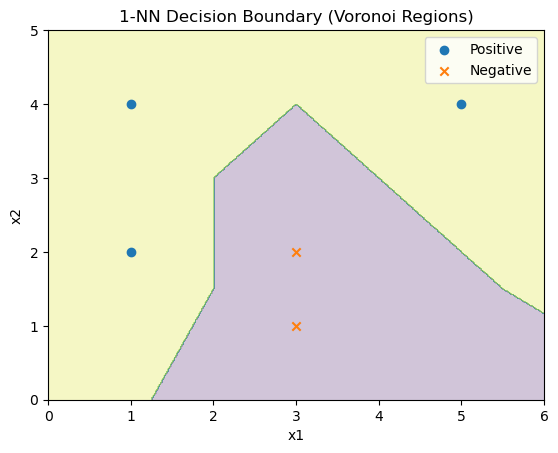

In [1]:
import numpy as np
import matplotlib.pyplot as plt

X_pos = np.array([[1,2],[1,4],[5,4]])
X_neg = np.array([[3,1],[3,2]])
X = np.vstack([X_pos, X_neg])
y = np.array([1,1,1,-1,-1])

def predict_1nn(point, X, y):
    dists = np.sum((X - point)**2, axis=1)
    return y[np.argmin(dists)]

x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]

preds = np.array([predict_1nn(p, X, y) for p in grid]).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, preds, alpha=0.25)  # decision regions
plt.scatter(X_pos[:,0], X_pos[:,1], marker='o', label='Positive')
plt.scatter(X_neg[:,0], X_neg[:,1], marker='x', label='Negative')
plt.title("1-NN Decision Boundary (Voronoi Regions)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

The 1-NN decision boundary is the union of perpendicular bisectors between each pair of neighboring points with different labels (the Voronoi boundaries). Each region of the plane is assigned the label of its closest point.

In [2]:
import numpy as np

pos = np.array([[100,2],[100,4],[500,4]])
neg = np.array([[300,1],[300,2]])
X = np.vstack([pos, neg])
y = np.array([1,1,1,-1,-1])

q = np.array([500,1])

def predict_1nn(point, X, y):
    dists = np.sum((X - point)**2, axis=1)
    return y[np.argmin(dists)]

print("Before scaling:", "Positive" if predict_1nn(q, X, y)==1 else "Negative")

mins = X.min(axis=0)
maxs = X.max(axis=0)
X_scaled = (X - mins) / (maxs - mins)
q_scaled = (q - mins) / (maxs - mins)

print("After scaling:", "Positive" if predict_1nn(q_scaled, X_scaled, y)==1 else "Negative")

Before scaling: Positive
After scaling: Negative


In [3]:
import numpy as np

def nan_aware_distance(x, z):
    mask = ~np.isnan(x)
    if mask.sum() == 0:
        return np.inf
    return np.sum((x[mask] - z[mask])**2) / mask.sum()

def predict_knn_missing(x, X_train, y_train):
    dists = np.array([nan_aware_distance(x, z) for z in X_train])
    return y_train[np.argmin(dists)]

Modify the distance computation so that, for a test point with missing features, distances are computed only over the shared non-missing coordinates, possibly re-normalized by the number of dimensions. Alternatively, impute missing features first and then run standard K-NN.

Even though the raw dimension is large, the intrinsic structure of images (correlated pixels, smooth shapes, edges) plus good feature representations means that nearest neighbors can still carry useful information.

## Problem 3:

**You are given a fully trained Perceptron model with weight vector w, along with training set D_TR and test set D_TE.**

**1. Your co-worker suggests evaluating $h(x) = sign(w \cdot x)$ for every $(x, y)$ in D_TR and D_TE. Does this help determine whether test error is higher than training error?**
**2. Why is there no need to compute training error explicitly for the Perceptron algorithm?**

In general, yes. Evaluating h(x) on D_TR and D_TE would let you compute training and test error and compare them. However, for the Perceptron on linearly separable data, there is no need to explicitly compute training error. The Perceptron algorithm only stops updating once it finds a weight vector that correctly classifies all training examples. So at convergence, the training error is guaranteed to be 0. So, you only need to compute test error on D_TE. The training error is already known: it’s zero (assuming the data is linearly separable and the algorithm has converged).

**2. Run the Perceptron algorithm by hand or in code on the following data: Positive class: (10, -2), Negative class: (12, 2).**

**Start with $w_0 = (0, 0)$ and a learning rate of 1. Compute how many updates are required until convergence. Write down the sequence of $w_i$ vectors.**

In [4]:
import numpy as np

X = np.array([[10, -2],
              [12,  2]])
y = np.array([+1, -1])

w = np.array([0, 0], dtype=int)
eta = 1

history = [w.copy()]
updates = 0

def misclassified(w, x, y):
    return y * (w @ x) <= 0

while True:
    changed = False
    for xi, yi in zip(X, y):
        if misclassified(w, xi, yi):
            w = w + eta * yi * xi
            history.append(w.copy())
            updates += 1
            changed = True
    if not changed:
        break

print("Total updates:", updates)
print("Final w:", w)
print("Sequence of w vectors:")
for i, wi in enumerate(history):
    print(f"w{i} = {wi}")

Total updates: 9
Final w: [  2 -18]
Sequence of w vectors:
w0 = [0 0]
w1 = [10 -2]
w2 = [-2 -4]
w3 = [ 8 -6]
w4 = [-4 -8]
w5 = [  6 -10]
w6 = [ -6 -12]
w7 = [  4 -14]
w8 = [ -8 -16]
w9 = [  2 -18]


## Problem 4: Reconstructing the Weight Vector

**Given the log of Perceptron updates:**

**| x | y | count |**

**|---|---|--------|**

**| (0, 0, 0, 0, 4) | +1 | 2 |**

**| (0, 0, 6, 5, 0) | +1 | 1 |**

**| (3, 0, 0, 0, 0) | -1 | 1 |**

**| (0, 9, 3, 6, 0) | -1 | 1 |**

**| (0, 1, 0, 2, 5) | -1 | 1 |**

**Assume learning rate = 1 and initial weight $w_0 = (0, 0, 0, 0, 0)$. Compute the final weight vector after all updates.**

In [5]:
import numpy as np

w = np.zeros(5, dtype=int)

updates = [
    (np.array([0,0,0,0,4]), +1, 2),
    (np.array([0,0,6,5,0]), +1, 1),
    (np.array([3,0,0,0,0]), -1, 1),
    (np.array([0,9,3,6,0]), -1, 1),
    (np.array([0,1,0,2,5]), -1, 1),
]

for x, y, count in updates:
    w += count * y * x

print("Final weight vector:", w)

Final weight vector: [ -3 -10   3  -3   3]


## Problem 5: Visualizing Perceptron Convergence

**Implement a Perceptron on a small 2D dataset with positive and negative examples. Plot the data points. After each update, visualize the decision boundary. Show how it converges to a stable separator.**

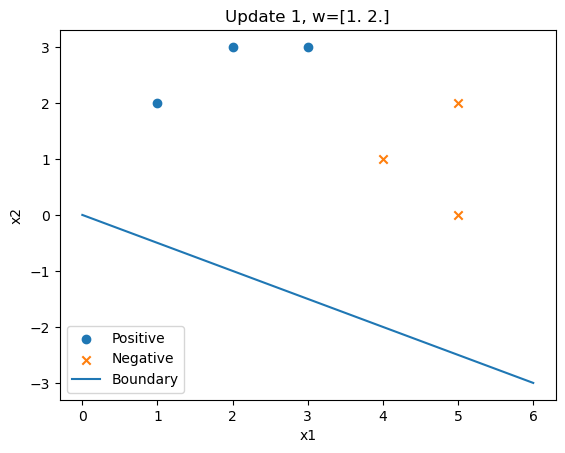

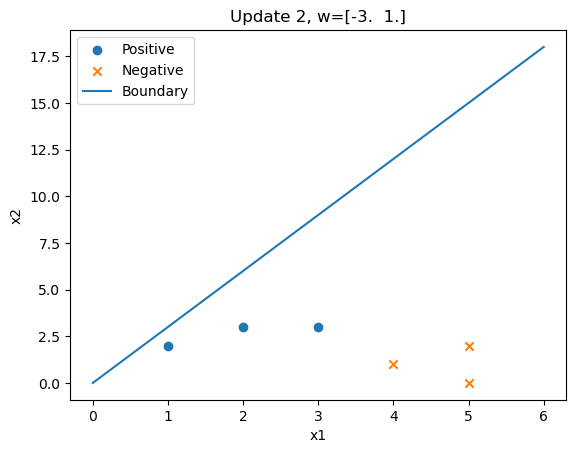

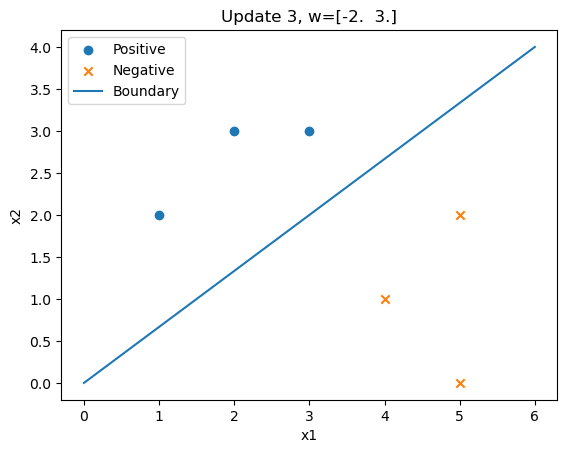

Converged w: [-2.  3.]
Total updates: 3


In [6]:
import numpy as np
import matplotlib.pyplot as plt

X = np.array([
    [1, 2], [2, 3], [3, 3], # positive
    [4, 1], [5, 2], [5, 0] # negative
])
y = np.array([1, 1, 1, -1, -1, -1])

w = np.zeros(2, dtype=float)
eta = 1.0

def plot_boundary(w, X, y, title=""):
    plt.figure()
    pos = y == 1
    neg = y == -1
    plt.scatter(X[pos,0], X[pos,1], marker='o', label='Positive')
    plt.scatter(X[neg,0], X[neg,1], marker='x', label='Negative')

    if abs(w[1]) > 1e-12:
        xs = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 100)
        ys = -(w[0] / w[1]) * xs
        plt.plot(xs, ys, label='Boundary')

    plt.title(title)
    plt.xlabel("x1"); plt.ylabel("x2")
    plt.legend()
    plt.show()

update_num = 0
for epoch in range(50):
    errors = 0
    for xi, yi in zip(X, y):
        if yi * (w @ xi) <= 0:
            w = w + eta * yi * xi
            update_num += 1
            errors += 1
            plot_boundary(w, X, y, title=f"Update {update_num}, w={w}")
    if errors == 0:
        break

print("Converged w:", w)
print("Total updates:", update_num)

We plotted the positive and negative examples in 2D. After each Perceptron update, we plotted the current decision boundary w⋅x = 0. Initially, the boundary is arbitrary (or degenerate at w=0). As the algorithm updates the weights on misclassified points, the line rotates and shifts until it reaches a stable separator where all training points are correctly classified. At that point, no further updates are made and the Perceptron has converged.